# Keep track of GPU usage



In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.4 GB  | Proc size: 156.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# Kills all GPU processes

In [0]:
!kill -9 -1

# Import libraries 

In [0]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2


# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#from __future__ import print_function

import keras
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

import tensorflow as tf

Using TensorFlow backend.


# Import files from the google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
cwd_train = "/content/gdrive/My Drive/comp551/data/train_max_x"
cwd_test = "/content/gdrive/My Drive/comp551/data/test_max_x"
cwd_targets = "/content/gdrive/My Drive/comp551/data/"

In [0]:
train_dataset = pd.read_pickle(cwd_train) 


targets = pd.read_csv(os.path.join(cwd_targets, 'train_max_y.csv'))
targets= targets.iloc[:,1]


#X_train, X_test, y_train, y_test = train_test_split(train_dataset, targets, test_size=0.2)
img_rows=128
img_cols=128

# Images preprocessing

In [0]:
THRESH = 235
ret, X_train_thresh = cv2.threshold(train_dataset , THRESH, 255, cv2.THRESH_BINARY)



In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train_thresh, targets, test_size=0.2)


# Deploy cells below to get the test dataset


In [0]:
test_dataset = pd.read_pickle(cwd_test)
X_test_set = test_dataset

In [0]:
#threshholding 
ret, X_test_set = cv2.threshold(X_test_set , THRESH, 255, cv2.THRESH_BINARY)

In [0]:
X_test_set = X_test_set.astype('float32')
X_test_set /= 255


In [0]:
if K.image_data_format() == 'channels_first':
  X_test_set = X_test_set.reshape(X_test_set.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else:
   X_test_set = X_test_set.reshape(X_test_set.shape[0], img_rows, img_cols, 1)
   input_shape = (img_rows, img_cols, 1)

In [0]:
#plt.imshow(X_test_set[10], cmap='gray')

# Scaling the images and specifying the input size

In [0]:
#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if K.image_data_format() == 'channels_first':
  X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else:
   X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
   X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
   input_shape = (img_rows, img_cols, 1)
#more reshaping

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape) 

X_train shape: (40000, 128, 128, 1)


In [0]:
import keras
#set number of categories
num_category = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

# Creating the model

In [0]:
#seems to be by far the best


model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))
BatchNormalization()
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))


BatchNormalization()
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))

model.add(Flatten())

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.5))
model.add(Dense(10))

model.add(Activation('softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:


model.compile(optimizer='Adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])



In [0]:
epochs=30
batch_size = 256

# NOTES: 
# batch size: 
# 256 converges, best so far


In [0]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/30





40000/40000 [==============================] - 60s 1ms/step - loss: 1.8580 - acc: 0.2723 - val_loss: 1.5961 - val_acc: 0.3843
Epoch 2/30
40000/40000 [==============================] - 54s 1ms/step - loss: 1.1360 - acc: 0.6053 - val_loss: 0.7943 - val_acc: 0.7351
Epoch 3/30
40000/40000 [==============================] - 54s 1ms/step - loss: 0.6582 - acc: 0.7845 - val_loss: 0.5405 - val_acc: 0.8315
Epoch 4/30
40000/40000 [==============================] - 54s 1ms/step - loss: 0.4586 - acc: 0.8542 - val_loss: 0.4583 - val_acc: 0.8540
Epoch 5/30
40000/40000 [==============================] - 54s 1ms/step - loss: 0.3374 - acc: 0.8922 - val_loss: 0.3706 - val_acc: 0.8848
Epoch 6/30
40000/40000 [==============================] - 54s 1ms/step - loss: 0.2590 - acc: 0.9171 - val_loss: 0.3326 - val_acc: 0.8974
Epoch 7/30
40000/40000 [==

# Graphs

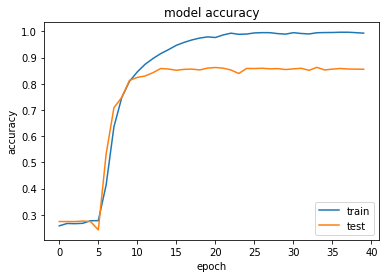

In [0]:

plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

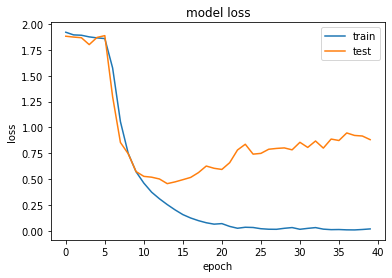

In [0]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
unique, counts = np.unique(targets, return_counts=True)

x=[0,1,2,3,4,5,6,7,8,9]
y=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000]

plt.bar(unique, counts)
plt.bar(unique, counts)

plt.yticks(y)
plt.xticks(x)
plt.title('Training Dataset Class Distribution')
plt.xlabel('Highest Numeric Value')
plt.ylabel('Number of Occurences')


plt.show()

# Thresholded Images

In [0]:
columns = 3
rows = 3
fig=plt.figure(figsize=(9, 9))
for i in range(1,10):
    
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train_thresh[i],cmap='gray')
plt.show()

In [0]:
columns = 3
rows = 3
fig=plt.figure(figsize=(9, 9))
for i in range(1,10):
    
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train_not_thresh[i],cmap='gray')
plt.show()


# Evaluate on the test set

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 


Test loss: 0.5967727069377899
Test accuracy: 0.835


# Predicting on the test dataset and creating a CSV

In [0]:
ynew = model.predict_classes(X_test_set)

In [0]:
Id = list(range(0, 10000))

In [0]:
Id = np.asarray(Id)

In [0]:
predictions = pd.DataFrame({'Id': Id, 'Label': ynew}, columns=['Id', 'Label'])

In [0]:
from google.colab import files
predictions.to_csv('04.11_attempt2.csv', index=False)